Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


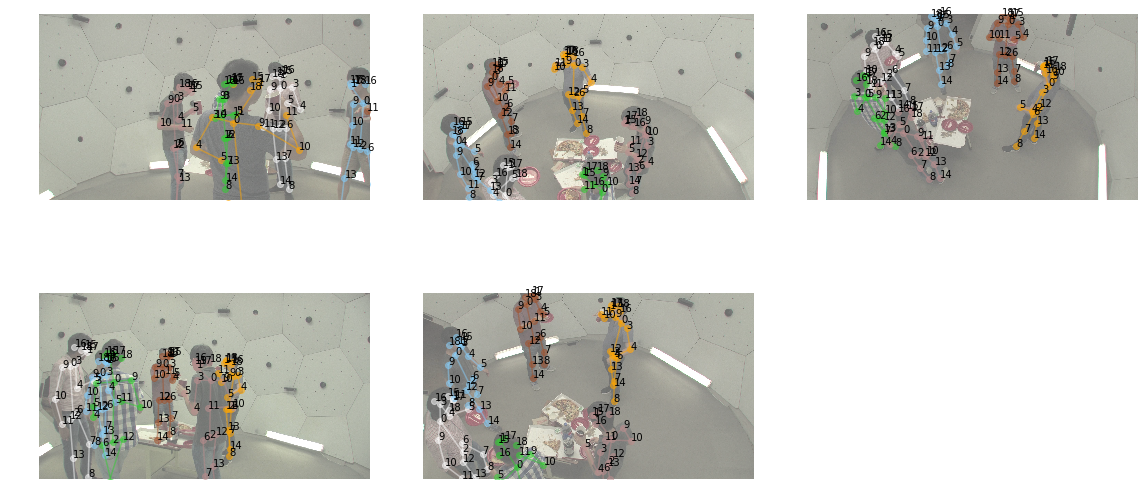

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['CMU']['data_root']
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d
from mvpose.data import cmu_panoptic
from cselect import color as cs
from random import shuffle


from openpose import OpenPose

pe = OpenPose(tmp=tmp)


FRAME = 1400

nodes = [0, 1, 2, 3, 4]
panels = [0, 0, 0, 0, 0]
# seq_name = '160224_haggling1'
# seq_name = '160422_ultimatum1'
seq_name = '160906_pizza1'

# valid_frames = list(range(300, 3758))  # ULTIMATUM
valid_frames = list(range(1000, 4458))  # PIZZA
# valid_frames = list(range(4209, 5315)) + list(range(6440, 8200))  # HAGGLING

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

fig = plt.figure(figsize=(16,8))

# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen',
         'rosybrown', 'sienna', 'plum', 'slategrey',
         'orchid', 'lightblue', 'azure', 'aliceblue',
         'darkblue', 'lightcoral', 'silver', 'mediumpurple',
         'lightskyblue']
shuffle(colors)

# n = 18
# colors = cs.rangecolor(n, (255, 0, 0), (0, 256, 0))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
#     ax.set_xlim([1200, 1800])
#     ax.set_ylim([1080, 300])
    
    for pid, points3d_weighted in Y:
        pts3d = points3d_weighted[:, 0:3].astype('float32')
        pts2d = cam.projectPoints(pts3d)
        pts2dT = pts2d.transpose()
        ax.scatter(pts2d[:, 0], pts2d[:, 1], color=colors[pid], alpha=0.5)
        for edge in body_edges:
            ax.plot(pts2dT[0, edge], pts2dT[1, edge],
                    color=colors[pid], alpha=0.5)
        for idx, (x, y) in enumerate(pts2d):
            if x >= 0 and x < w:
                if y >= 0 and y < h:
                    ax.text(x, y, str(idx))
        
    
plt.tight_layout()

plt.show()

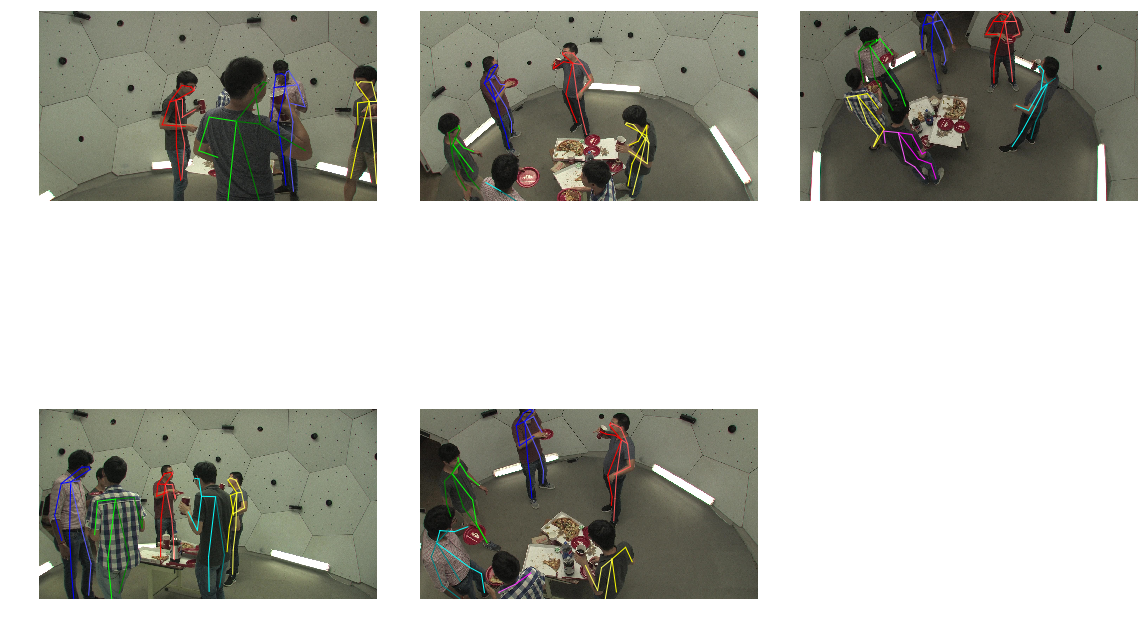

In [2]:
predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, FRAME)

colors = ['red', 'blue', 'green', 'yellow', 'teal', 'magenta']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16, 12))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(pred):
        draw_mscoco_human2d(ax, human[:, 0:2], color=colors[pid])

    
plt.tight_layout()
plt.show()

In [3]:
# valid_frames = list(range(300, 3166))
# for frame in valid_frames:
#     if frame % 10 == 0:
#         print('frame', frame)
#     Im, Y, calib = cmu_panoptic.get(root, seq_name, 
#                                     panels, nodes, frame=frame,
#                                     ignore_videos=True)
#     predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)

In [4]:
# valid_frames = list(range(300, 3166))
# valid_frames = list(range(300, 400))


Calib = []
poses_per_frame = []
poses_per_frame_lookup = {}
Pos3d = {}

_start = time()
for frame in valid_frames:
    if frame % 12 == 0:
        print('frame', frame)
    Im, Y, calib = cmu_panoptic.get(root, seq_name, 
                                    panels, nodes, frame=frame,
                                    ignore_videos=True)
#     Calib.append(calib)
    Pos3d[frame] = Y
    predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)
    poses_per_frame.append(predictions)
    poses_per_frame_lookup[frame] = predictions
_end = time()
Calib = calib
print('elapsed', _end - _start)

frame 1008
frame 1020
frame 1032
frame 1044
frame 1056
frame 1068
frame 1080
frame 1092
frame 1104
frame 1116
frame 1128
frame 1140
frame 1152
frame 1164
frame 1176
frame 1188
frame 1200
frame 1212
frame 1224
frame 1236
frame 1248
frame 1260
frame 1272
frame 1284
frame 1296
frame 1308
frame 1320
frame 1332
frame 1344
frame 1356
frame 1368
frame 1380
frame 1392
frame 1404
frame 1416
frame 1428
frame 1440
frame 1452
frame 1464
frame 1476
frame 1488
frame 1500
frame 1512
frame 1524
frame 1536
frame 1548
frame 1560
frame 1572
frame 1584
frame 1596
frame 1608
frame 1620
frame 1632
frame 1644
frame 1656
frame 1668
frame 1680
frame 1692
frame 1704
frame 1716
frame 1728
frame 1740
frame 1752
frame 1764
frame 1776
frame 1788
frame 1800
frame 1812
frame 1824
frame 1836
frame 1848
frame 1860
frame 1872
frame 1884
frame 1896
frame 1908
frame 1920
frame 1932
frame 1944
frame 1956
frame 1968
frame 1980
frame 1992
frame 2004
frame 2016
frame 2028
frame 2040
frame 2052
frame 2064
frame 2076
frame 2088

In [5]:
from mvpose.baseline.tracking import tracking, Track

_start = time()
tracks = tracking(Calib, poses_per_frame,
                  epi_threshold=80,
                  scale_to_mm=10,
                  max_distance_between_tracks=200,
                  actual_frames=valid_frames,
                  min_track_length=4,
                  merge_distance=150,
                  z_axis=1,
                  last_seen_delay=5)
_end = time()
print('elapsed', _end - _start)
print("#tracks", len(tracks))
print('')
for track in tracks:
    print('\ttrack length:', len(track))

elapsed 394.51849269866943
#tracks 123

	track length: 928
	track length: 149
	track length: 70
	track length: 611
	track length: 559
	track length: 23
	track length: 11
	track length: 739
	track length: 8
	track length: 16
	track length: 8
	track length: 9
	track length: 67
	track length: 9
	track length: 106
	track length: 4
	track length: 13
	track length: 73
	track length: 4
	track length: 1746
	track length: 4
	track length: 132
	track length: 4
	track length: 7
	track length: 56
	track length: 9
	track length: 191
	track length: 4
	track length: 878
	track length: 13
	track length: 5
	track length: 17
	track length: 17
	track length: 6
	track length: 5
	track length: 26
	track length: 9
	track length: 4
	track length: 5
	track length: 10
	track length: 110
	track length: 5
	track length: 15
	track length: 27
	track length: 1126
	track length: 1223
	track length: 4
	track length: 14
	track length: 26
	track length: 46
	track length: 33
	track length: 5
	track length: 9
	track leng

In [6]:
is_smoothing = True
if is_smoothing:
    _start = time()
    tracks_ = []
    for track in tracks:
        track = Track.smoothing(track, 
                                sigma=2,
                                interpolation_range=20)
        tracks_.append(track)
    tracks = tracks_
    _end = time()
    print("elapsed", _end - _start)

n frames 928
n frames 149
n frames 70
n frames 611
n frames 559
n frames 23
n frames 11
n frames 739
n frames 8
n frames 16
n frames 8
n frames 9
n frames 67
n frames 9
n frames 106
n frames 4
n frames 13
n frames 73
n frames 4
n frames 1746
n frames 4
n frames 132
n frames 4
n frames 7
n frames 56
n frames 9
n frames 191
n frames 4
n frames 878
n frames 13
n frames 5
n frames 17
n frames 17
n frames 6
n frames 5
n frames 26
n frames 9
n frames 4
n frames 5
n frames 10
n frames 110
n frames 5
n frames 15
n frames 27
n frames 1126
n frames 1223
n frames 4
n frames 14
n frames 26
n frames 46
n frames 33
n frames 5
n frames 9
n frames 69
n frames 169
n frames 44
n frames 9
n frames 5
n frames 63
n frames 52
n frames 579
n frames 30
n frames 8
n frames 82
n frames 8
n frames 1208
n frames 10
n frames 15
n frames 48
n frames 12
n frames 128
n frames 65
n frames 7
n frames 15
n frames 607
n frames 324
n frames 5
n frames 5
n frames 133
n frames 382
n frames 6
n frames 516
n frames 494
n fram

In [7]:
def calculate_pcp_score(Y, detections):
    alpha = 0.2
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
    
    Y_kth = []
    for _, gt in Y:
        Y_kth.append(gt[:, 0:3])
    Y_kth = kth.transform3d_from_mscoco(Y_kth)
        
    for gtid, gt in enumerate(Y_kth):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

In [8]:
PER_GTID = {}
for idx, frame in enumerate(valid_frames):
    Humans = []
    for track in tracks:
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
    
    Y = Pos3d[frame]
    Y = cmu_panoptic.transform_y(Y)
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = calculate_pcp_score(Y, Humans)
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)

In [9]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  0
	uarms: 0.8144881434355119
	larms: 0.7518796992481203
	ulegs: 0.9188837478311163
	llegs: 0.7520242914979757
	avg:   0.809318970503181
actor  1
	uarms: 0.6709080393290919
	larms: 0.5467032967032966
	ulegs: 0.5997686524002314
	llegs: 0.48293811451706187
	avg:   0.5750795257374205
actor  2
	uarms: 0.8637941006362059
	larms: 0.7822440717177559
	ulegs: 0.9243782533256217
	llegs: 0.7860034702139965
	avg:   0.839104973973395
actor  3
	uarms: 0.6878253325621747
	larms: 0.3624927703875072
	ulegs: 0.39806246385193755
	llegs: 0.13678426836321572
	avg:   0.3962912087912088
actor  4
	uarms: 0.8580104106419896
	larms: 0.5276171197223829
	ulegs: 0.7229612492770388
	llegs: 0.5575477154424523
	avg:   0.6665341237709659
actor  5
	uarms: 0.9160519845451353
	larms: 0.7978573937478047
	ulegs: 0.6773796979276432
	llegs: 0.47910080786793113
	avg:   0.7175974710221286

avg*:   0.6673210456330501


In [10]:
# ULTIMATUM UNSMOOTHED
# actor  0
# 	uarms: 0.7957418496340652
# 	larms: 0.8446440452428476
# 	ulegs: 0.6087824351297405
# 	llegs: 0.5133067198935463
# 	avg:   0.6906187624750498
# actor  1
# 	uarms: 0.6576544943820225
# 	larms: 0.48700842696629215
# 	ulegs: 0.32092696629213485
# 	llegs: 0.2796699438202247
# 	avg:   0.4363149578651685
# actor  2
# 	uarms: 0.9503036996134733
# 	larms: 0.9058531198233021
# 	ulegs: 0.9665930425179459
# 	llegs: 0.9574820541137493
# 	avg:   0.9450579790171175

# avg*:   0.6906638997857786


# PIZZA UNSMOOTHED
# actor  0
# 	uarms: 0.8155002891844997
# 	larms: 0.7524580682475419
# 	ulegs: 0.8893869288606131
# 	llegs: 0.6941873915558127
# 	avg:   0.7878831694621168
# actor  1
# 	uarms: 0.641122035858878
# 	larms: 0.5185078079814922
# 	ulegs: 0.5281954887218046
# 	llegs: 0.3954598033545402
# 	avg:   0.5208212839791787
# actor  2
# 	uarms: 0.8191150954308849
# 	larms: 0.7377096587622903
# 	ulegs: 0.8863504916136495
# 	llegs: 0.7611336032388664
# 	avg:   0.8010772122614228
# actor  3
# 	uarms: 0.5763447079236553
# 	larms: 0.2599768652400231
# 	ulegs: 0.2674956622325043
# 	llegs: 0.06174089068825911
# 	avg:   0.29138953152111047
# actor  4
# 	uarms: 0.7861480624638519
# 	larms: 0.43045112781954886
# 	ulegs: 0.5717177559282822
# 	llegs: 0.2689415847310584
# 	avg:   0.5143146327356853
# actor  5
# 	uarms: 0.87284861257464
# 	larms: 0.7692307692307693
# 	ulegs: 0.6162627327010889
# 	llegs: 0.36951176677204073
# 	avg:   0.6569634703196348

# avg*:   0.5954082167131914

### debugging

In [11]:
# poses_per_frame_lookup.keys()

In [12]:
# FRAME = 4347
# predictions = poses_per_frame_lookup[FRAME]
# Im, Y, calib = cmu_panoptic.get(root, seq_name, 
#                                     panels, nodes, frame=FRAME)

# colors = ['red', 'blue', 'green', 'yellow', 'teal', 'magenta']

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fig = plt.figure(figsize=(16, 8))
# for idx, (im, pred) in enumerate(zip(Im, predictions)):
#     ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
#     ax.imshow(im)
#     ax.set_xlim([0, 1920])
#     ax.set_ylim([1080, 0])
    
#     for pid, human in enumerate(pred):
#         draw_mscoco_human2d(ax, human[:, 0:2], color=colors[pid])

    
# plt.tight_layout()
# plt.show()

In [13]:
# Humans = []
# for track in tracks:
#     pose = track.get_by_frame(FRAME)
#     if pose is not None:
#         Humans.append(pose)

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fig = plt.figure(figsize=(16, 6))
# for idx, (im, cam) in enumerate(zip(Im, Calib)):
#     ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
#     ax.imshow(im)
#     ax.set_xlim([0, 1920])
#     ax.set_ylim([1080, 0])
    
#     for pid, human in enumerate(Humans):
#         draw_mscoco_human(ax, human, cam, 
#                           color=colors[pid], linewidth=2)

    
# plt.tight_layout()
# plt.show()

In [14]:
# colors = ['red', 'blue', 'green', 'yellow', 'teal', 'magenta']
# colors = ['red', 'magenta', 'orange', 'yellow', 'teal', 'blue']

# Humans = []
# for track in tracks:
#     pose = track.get_by_frame(FRAME)
#     if pose is not None:
#         Humans.append(pose)

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fig = plt.figure(figsize=(16, 12))
# for idx, (im, cam) in enumerate(zip(Im[0:4], Calib[0:4])):
#     ax = fig.add_subplot(2, 2, idx+1); ax.axis('off')
#     ax.imshow(im)
#     ax.set_xlim([100, 1620])
#     ax.set_ylim([1080, 0])
    
#     for pid, human in enumerate(Humans):
#         draw_mscoco_human(ax, human, cam, 
#                           color=colors[pid], linewidth=2)

    
# plt.tight_layout()
# plt.show()

In [15]:
# from mvpose.plot.limbs import draw_mscoco_human3d
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# human = Humans[0]
# vmin = np.min(human)
# vmax = np.max(human)

# ax.set_xlim([vmin, vmax])
# ax.set_ylim([vmin, vmax])
# ax.set_zlim([vmin, vmax])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# draw_mscoco_human3d(ax, human, 'red')

# plt.show()

## MOTA

https://github.com/cheind/py-motmetrics

In [16]:
import motmetrics as mm
from mvpose.baseline.baseline import distance_between_poses

acc = mm.MOTAccumulator(auto_id=True)
scale_to_mm = 10
MOTA_distance = 200  # [mm]

def cleanup(Humans):
    Result = []
    for human in Humans:
        remove = True
        for pt in human:
            if pt is not None:
                remove = False
                break
        if not remove:
            Result.append(human)
        
    return Result

possible_ids_lookup = {}
n_possible_ids = 0
for frame in valid_frames:
    Y = Pos3d[frame]
    Y = cmu_panoptic.transform_y(Y)
    
    Humans = []
    
    gtids = []
    trids = []
    
    for tid, track in enumerate(tracks):
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
            trids.append(tid)
    Humans = cleanup(Humans)
    
    for pid, _ in Y:
        gtids.append(pid)
    
    n = len(gtids)
    m = len(trids)
    
    distances = np.empty((n, m))
    for i, gt in enumerate(Y):
        for j, pr in enumerate(Humans):
            
            try:
                d = distance_between_poses(gt[1][:,0:3], pr, z_axis=1)
            except:
                print("GT", gt)
                print("Pr", pr)
                raise
            
            d = d * scale_to_mm
            
            if d <= MOTA_distance:
                distances[i, j] = d
                
                # track possible identity switches
                if (frame, i) in possible_ids_lookup:
                    possible_ids_lookup[frame, i] += 1
                else:
                    possible_ids_lookup[frame, i] = 1
                
                if possible_ids_lookup[frame, i] == 2:
                    n_possible_ids += 1
                
            else:
                distances[i, j] = np.nan
    
    acc.update(gtids, trids, distances)
    
    
mh = mm.metrics.create()
summary = mh.compute(acc, 
                     metrics=['num_frames', 'mota', 'motp'], 
                     name='acc')

print(summary)

     num_frames     mota       motp
acc        3458  0.92844  45.567744


In [17]:
56/n_possible_ids

0.22857142857142856

In [18]:
summary = mh.compute(acc, 
                     metrics=mm.metrics.motchallenge_metrics, 
                     name='acc')

strsummary = mm.io.render_summary(
    summary, 
    formatters=mh.formatters, 
    namemap=mm.io.motchallenge_metric_names
)
print(strsummary)

     IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs  FM  MOTA   MOTP
acc 34.4% 34.0% 34.8% 97.8% 95.4%  7  7  0  0 945 441  55  44 92.8% 45.568


In [19]:
# HAGGLING (not smoothed)
#      num_frames     mota       motp
# acc        2328  0.92161  32.946946

# PIZZA (smoothed)
#    num_frames      mota       motp
# acc        2866  0.931444  45.519765

# not smoothed
#      num_frames     mota       motp
# acc        2866  0.92662  40.093258

# ULTIMATUM (default)

# num_frames      mota       motp
# acc        2553  0.877207  37.555424

# Haggeling

#      IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs   FM  MOTA   MOTP
# acc 60.6% 60.0% 61.1% 95.6% 93.9%  5  5  0  0 476 335  27  109 89.1% 36.263

# 3DPCK

In [20]:
from mvpose.evaluation import pck3d


def get_3DPCK_for_frame(pos3d, H):

    Y_kth = []
    for _, gt in pos3d:
        Y_kth.append(gt[:, 0:3])
    Y_kth = kth.transform3d_from_mscoco(Y_kth)
    
    
    total = []
    for gt in Y_kth:
        if gt is None:
            continue
        H_pred = pred_kth = kth.transform3d_from_mscoco(H)
        acc = [0]
        for pred in H_pred:
            acc.append(pck3d.evaluate(gt, pred, scale_to_mm=10))

        total.append(max(acc))
    if len(total) > 0:
        return np.mean(total)
    else:
        return -1  # nothing to find
    
    
TOTAL_3DPCK = []
for frame in valid_frames:
    Humans = []
    for track in tracks:
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
    
    if frame % 120 == 0:
        print("Humans " + str(frame), len(Humans))
    
    Y = Pos3d[frame]
    Y = cmu_panoptic.transform_y(Y)
    
    score = get_3DPCK_for_frame(Y, Humans)
    TOTAL_3DPCK.append(score)
    
# print(np.mean(TOTAL_3DPCK))

TOTAL_3DPCK_surv = [v for v in TOTAL_3DPCK if v > -0.1]

print("#frames", len(TOTAL_3DPCK))
print("#frames with no gt:", len(TOTAL_3DPCK) - len(TOTAL_3DPCK_surv))

print(np.mean(TOTAL_3DPCK_surv))

Humans 1080 5
Humans 1200 6
Humans 1320 5
Humans 1440 6
Humans 1560 6
Humans 1680 5
Humans 1800 5
Humans 1920 7
Humans 2040 7
Humans 2160 6
Humans 2280 6
Humans 2400 6
Humans 2520 6
Humans 2640 6
Humans 2760 6
Humans 2880 6
Humans 3000 6
Humans 3120 6
Humans 3240 6
Humans 3360 6
Humans 3480 6
Humans 3600 6
Humans 3720 6
Humans 3840 6
Humans 3960 6
Humans 4080 7
Humans 4200 7
Humans 4320 7
Humans 4440 6
#frames 3458
#frames with no gt: 0
0.8837078961139112


In [21]:
# plt.plot(valid_frames, TOTAL_3DPCK)